# Ladekurve

In dieses Notebook versuchen wir die Ladekurven von e-Fahrzeuge zu bestimmen. Dies machen wir mit den gelieferten Daten von unserer OBD Stecker die in verschiedenen Autos eingebaut sind. 

Aber zuerst laden wir die notwendige Python Modulen.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ladekurve" data-toc-modified-id="Ladekurve-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ladekurve</a></span></li><li><span><a href="#Bestimmung-der-Ladevorgang" data-toc-modified-id="Bestimmung-der-Ladevorgang-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bestimmung der Ladevorgang</a></span><ul class="toc-item"><li><span><a href="#Hyundai-Charging-Curves" data-toc-modified-id="Hyundai-Charging-Curves-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Hyundai Charging Curves</a></span><ul class="toc-item"><li><span><a href="#Ladekurven-am-bestimmte-Charge-station-(Charge-Point-in-Zukunft)" data-toc-modified-id="Ladekurven-am-bestimmte-Charge-station-(Charge-Point-in-Zukunft)-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Ladekurven am bestimmte Charge station (Charge Point in Zukunft)</a></span></li><li><span><a href="#Komplett-Ladekurve-auch-Temperatur-abhängig" data-toc-modified-id="Komplett-Ladekurve-auch-Temperatur-abhängig-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Komplett Ladekurve auch Temperatur abhängig</a></span></li><li><span><a href="#Ladekurve-Modell" data-toc-modified-id="Ladekurve-Modell-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Ladekurve Modell</a></span></li></ul></li></ul></li><li><span><a href="#Andere-Autohersteller" data-toc-modified-id="Andere-Autohersteller-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Andere Autohersteller</a></span><ul class="toc-item"><li><span><a href="#Tesla" data-toc-modified-id="Tesla-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Tesla</a></span></li><li><span><a href="#Kia" data-toc-modified-id="Kia-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Kia</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime, sys, datetime, warnings
sys.path.append('../chargecurve/')
from scipy.optimize import curve_fit
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_charges
from chargecurve import AutoCharge, ChargingCurve
from plot import charges, chargecurvestation, fullchargecurve
warnings.filterwarnings('ignore')

Um die Daten besser zu betrachten, schreiben wir ein paar Python Classes. 

+ AutoCharge: 

Diese Class definiert einen einzigen Ladevorgang. Hier können wir die für uns wichtige Information des Vorganges sammeln und bestimmte Kalkulationen machen wie Ladegeschwindigkeit, Ladedauer, etc.

+ ChargingCurve:

Diese Class sammel alle Daten von mehrere Ladevorgänge und erzeugt/sortiert wichtige Information von der gesamten Ladedaten. Zum Beispiel, hier können wir die Ladekurve darstellen für verschiedenen ChargePoints und verschiedenen Temperatur.

Diese Classes befinden sich in the eclever_chargingCurve.py datei.

# Bestimmung der Ladevorgang

Um die Automatisierung die Bestimmung des Ladevorganges folgen wir diese Schritte:

1. Zuerst wird es definiert, unter welche Bedingungen das Auto gerade lädt. 

Diese Bedingungen sind:

+ Der rpmMotor == 0
+ BatteryCurrent < 0 (Strom fließt in der Akku)

In der Tat, mit der aktuell Daten Qualität, diese Bedingungen änder sich von Auto Model zu Model. 
z.B.  Für Tesla: BatteryCurrent > 0  and rpmMotor <= 0

Dies soll in für die Zukunft berücksichtigen.

2. Wir nutzen die "get_peaks" Funktion, um zu bestimmen den Anfang und Ende des Ladevorganges. Diese Funktion nutzt die Scipy find_peaks Methode.

Jetzt können wir ein paar Beispiele mit echter Daten sehen.

## Hyundai Charging Curves


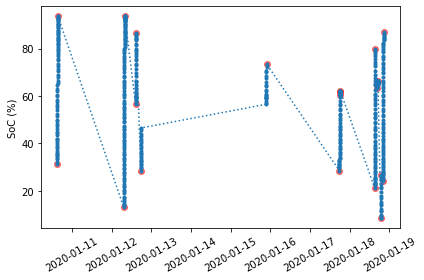

In [2]:
#load hyudai data
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2020,1,9)) \
& (hyundai.timestamp < datetime.datetime(2020,1,22)) \


#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

# plot SOC and peaks_id to check if the peaks were correctly determined
charges(hyundai[mask], peaks_id)

Das Graph oben zeigt die Ladedaten nach filtrieren mit dem get_peaks Funktion. Die roten Punkte zeigen den Anfang und ende die Ladevorgänge. In allgemein, die Algorithmus funktioniert gut. Es gibt manchmal Probleme wo die Angang und Ende punkte sehr weit entfernt voneinander liegen, wie z.B., die vierte Ladung im Graph. Solche Probleme sind in einen weiteren Schritt behoben, wo wie begrenzt die Ladevorgänge die nicht länger als 5 Stunden (das können wir bei Bedarf ändern).

### Ladekurven am bestimmte Charge station (Charge Point in Zukunft)

Jetzt können wir Ladekurven am verschiedenen Charge Stations darstellen (Gerade haben wir nicht die Möglichkeit um die Kurve an die ChargePoint zu verknüpfen, weil diese Information ist für die derzeitigen Daten verloren, in die Zukunft dies soll gelöst werden)

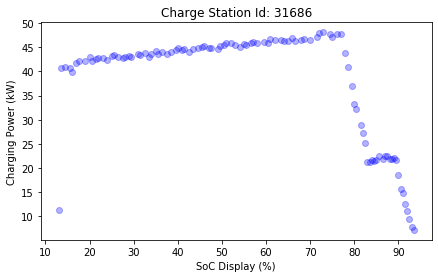

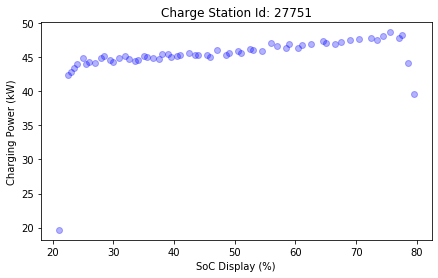

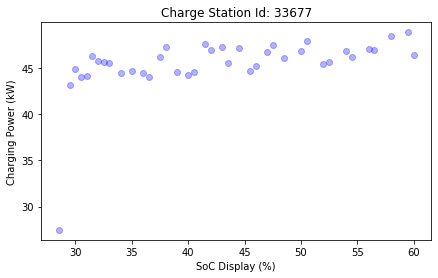

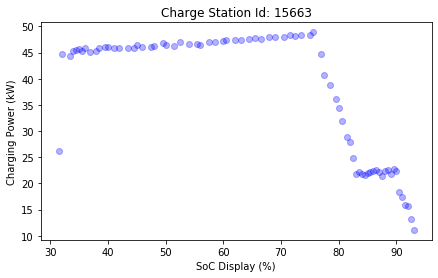

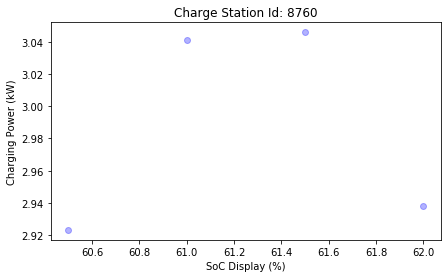

In [3]:
# collect charging data as AutoCharge objects
hyundai_charges = collect_charges(hyundai[mask], peaks_id)

#plot Charging curves for five Charge Stations
chargecurvestation(hyundai_charges[:6])

### Komplett Ladekurve auch Temperatur abhängig

Wir können also die gesamten Ladedaten darstellen mit aller verfügbare Daten und können wir auch die abhängig von der Akkutemperatur darstellen.

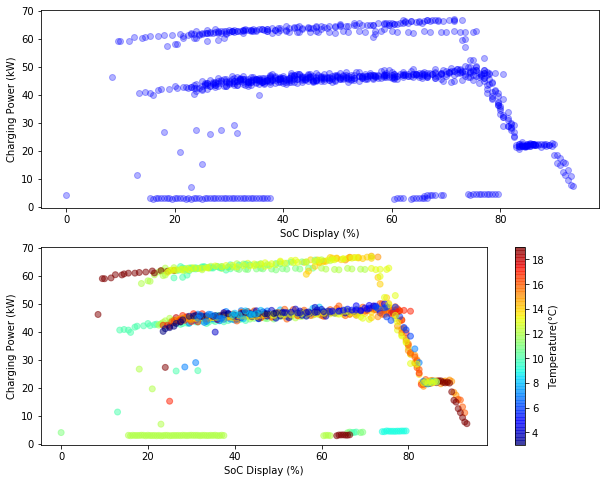

In [4]:
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,9)) 

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

hyundai_charges = collect_charges(hyundai[mask], peaks_id)


fig = plt.figure(figsize= (10,8))
ax = fig.add_subplot(211)
ax = fullchargecurve(hyundai_charges)
ax = fig.add_subplot(212)
ax = fullchargecurve(hyundai_charges, temp=True)

Wir können auch die komplette Ladekurve bei eine bestimmte Akku Temperatur plotten.  Im Zukunft ist auch die Idee die Kurven abhängig von der Außentemperatur zu erstellen.

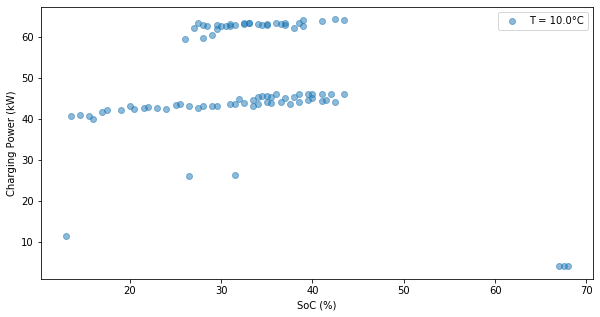

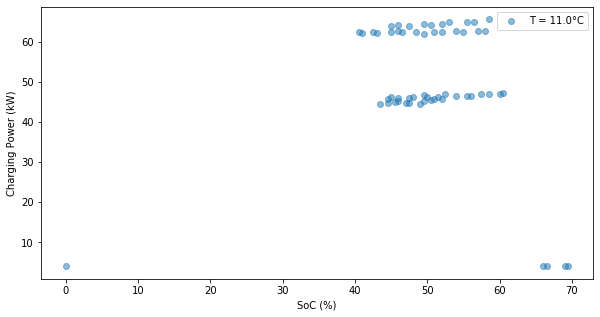

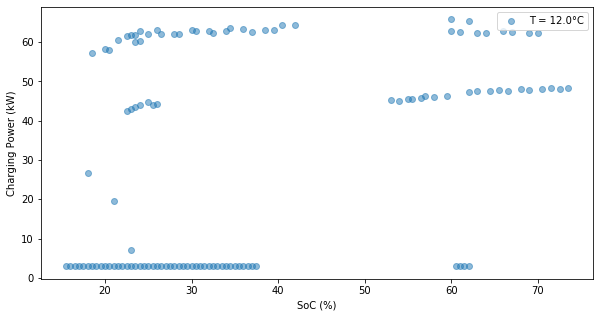

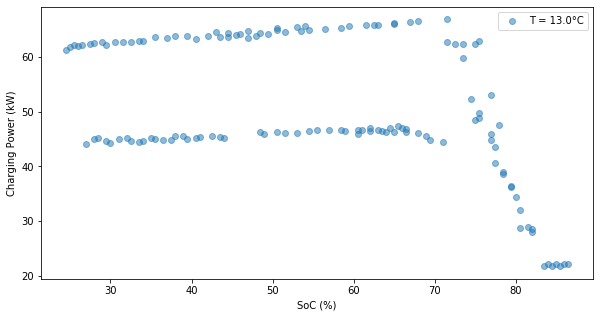

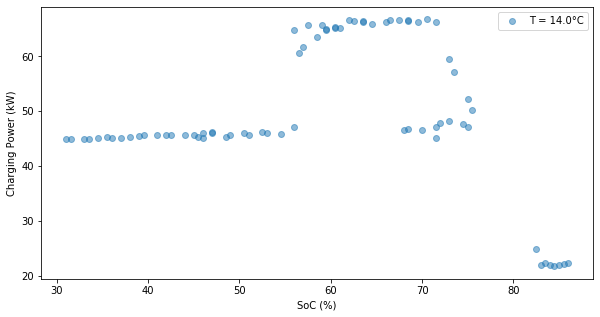

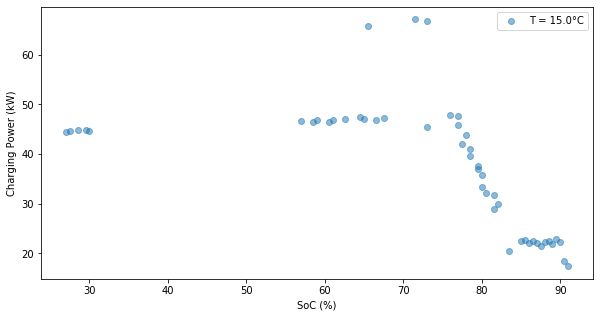

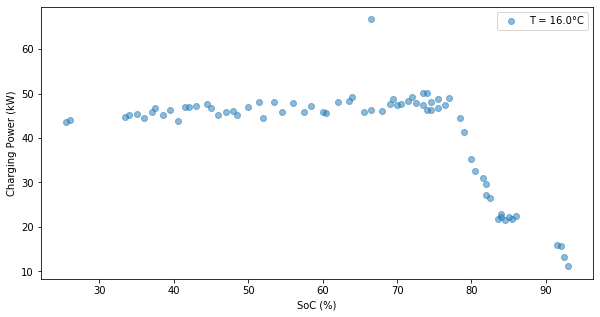

In [5]:
#collect data to build a ChargeCurve object
p = pd.concat([charge.power for charge in hyundai_charges])
soc = pd.concat([charge.soc_display for charge in hyundai_charges])
t = pd.concat([charge.battery_temp for charge in hyundai_charges])
cp = np.concatenate([[charge.chargestation_id for n in range(len(charge.power))] \
                     for charge in hyundai_charges])

# instantiate the ChargingCurve object
HyundaiChargeCurve = pd.DataFrame({'soc_display':soc, 'power':p, 'battery_temp':t, 'chargepoint_id':cp})
HyundaiChargeCurve = ChargingCurve(HyundaiChargeCurve.sort_values('soc_display'))

#get available battery temperatures and plot the Charging curve at different T
temps=np.sort(HyundaiChargeCurve.data.battery_temp.unique())

#plot only from 10 to 16 °C
for i,t in enumerate(temps[7:14]):
    fig = plt.figure(figsize=(200,5))
    X = HyundaiChargeCurve.tempCurve(t).soc_display
    Y = HyundaiChargeCurve.tempCurve(t).power
    fig.add_subplot(1,len(temps), i+1)
    plt.plot(X,Y, 'o', alpha = 0.5, label = f'T = {t}°C')
    plt.xlabel('SoC (%)')
    plt.ylabel('Charging Power (kW)')
    plt.legend()


### Ladekurve Modell

In die ChargingCurve class habe ich auch eine Methode implementiert, die eine Polynomfunktion an die Daten fit. Die kann man nutzen um wichtige Information zu bestimmen wie z.B., die verbleibende Akku Ladezeit, etc. Wenn wir alle Information über Außen und Akku Temperatur haben können, wo diese Funktion nutzen können für die gegebene Bedingungen.

Unten ist ein Beispiel wie diese Polynomfunktion angepasst wird an eine die Ladekurve von den Hyundai, die wir zurzeit betrachten.

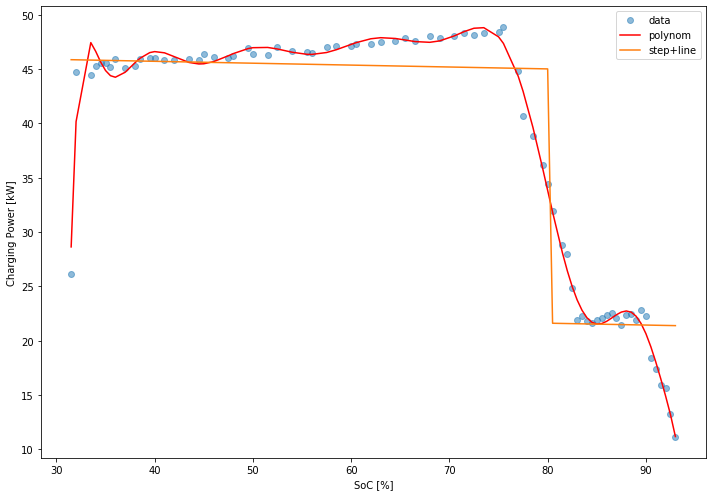

In [6]:
# step function plus a line
def rect1(x, a, b, c, d,e):
    return  np.where((a > x), b, c) + d +x*e

# charging point Id
cp =15663

# data to plot
x = HyundaiChargeCurve.ChargePointCurve(cp).soc_display
Y = HyundaiChargeCurve.ChargePointCurve(cp).power
#fitted model for the charging curve at Charge Point ID = cp
model = HyundaiChargeCurve.ChargePointCurveModel(cp)

# Fit the reci1 function to the data
popt, pcov = curve_fit(rect1, x, Y, p0=[80,40,1,-1,0.2])

# create the figure
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
plt.plot(x, Y, 'o', alpha=0.5, label='data')
plt.plot(x,model(x),'r-', label='polynom')
plt.plot(x, rect1(x, *popt), '-', label='step+line')
plt.xlabel('SoC [%]')
plt.ylabel('Charging Power [kW]')
plt.legend()
plt.tight_layout()

Noch ein weiteres Beispiel einer Umsetzung der AutoCharge class ist das, wir können einfache Statistiken Daten erzeugen. Unten z.B., ist eine Einschätzung die durchschnittliche Ladezeit und Ladegeschwindigkeit von dem Hyundai Auto an die gegebenen Charging Points.

In [7]:
# collect data from singel charges
_ =pd.DataFrame({'ChargeStation': [char.chargestation_id for char in hyundai_charges],
             'ChargingTime': [char.charging_time for char in hyundai_charges],
             'ChargingSpeed': [char.charge_speed_soc for char in hyundai_charges]})

# aggregate by chargeStation and get mean values
_ = _.groupby('ChargeStation').mean()

#rename columns
_.columns= ['ChargingTime_mean', 'ChargingSpeed_mean']
_

ChargingTime_mean  ChargingSpeed_mean
ChargeStation                                       
8760.0                  1.088611           12.172512
15663.0                 0.470278          130.773774
19884.0                 0.098333          177.966102
21247.0                 0.342500          162.043796
21362.0                 0.319444          164.347826
27751.0                 0.392500          149.044586
30362.0                 0.335833            8.933002
31686.0                 0.646667          124.484536
33677.0                 0.293472          131.388890
33701.0                 0.238056          197.432905
33729.0                 0.362222          175.306748
34924.0                 0.404722          171.722718
35321.0                 0.256389          200.866739
43408.0                 0.238611          203.259604

# Andere Autohersteller
Hier sehen wir Ladekurven von anderen Hersteller

## Tesla

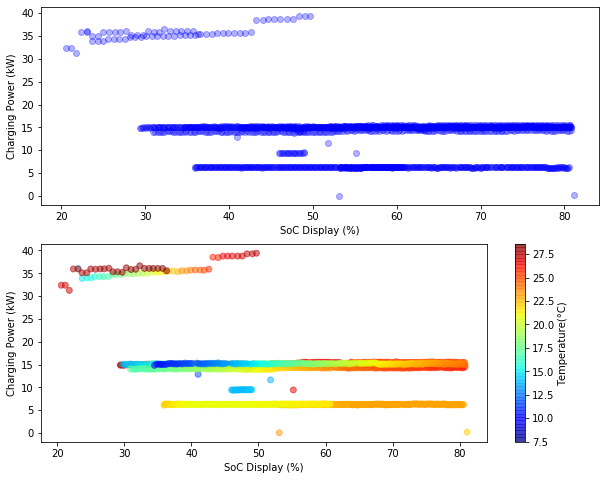

In [8]:
#load tesla data
tesla = load_base2_ftp('ecu_bcddc2ceb734')
tesla = tesla[tesla.model == 'TESLA_S']

#select while charging data, for Tesla the conditions are as below
mask = (tesla.hvBatteryCurrent > 0) & (tesla.rpmEmotor <=0) 

#find peaks to extract charging curves
peaks_id = get_peaks(tesla[mask], 'hvSocActualDisplay')

#collect all data for each charging curve at store it as AutoCharge() objects
tesla_charges = collect_charges(tesla[mask],peaks_id)

fig = plt.figure(figsize= (10,8))
ax = fig.add_subplot(211)
ax = fullchargecurve(tesla_charges)
ax = fig.add_subplot(212)
ax = fullchargecurve(tesla_charges, temp=True)

## Kia

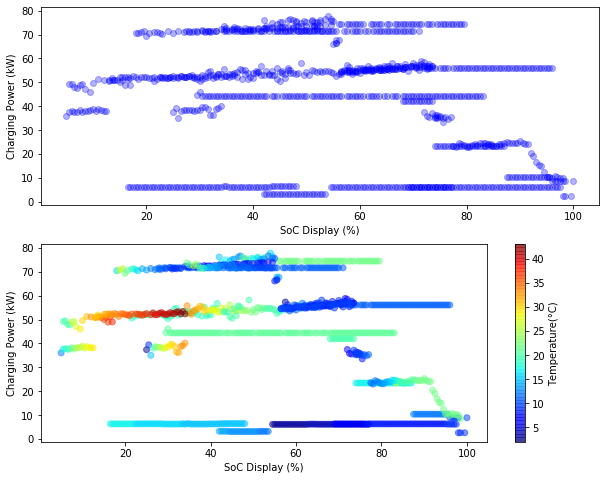

In [9]:
#load kia data
kia = load_base2_ftp('ecu_bcddc2d0718c')
kia = kia[kia.model == 'KIAENIRO']

#select while charging data, for kia the conditions are as below
mask = (kia.hvBatteryCurrent < 0) & (kia.rpmEmotor <=0) \
& (kia.timestamp > datetime.datetime(2020,1,13)) \

#find peaks to extract charging curves
peaks_id = get_peaks(kia[mask], 'hvSocActualDisplay')

kia_charges = collect_charges(kia[mask], peaks_id)

fig = plt.figure(figsize= (10,8))
ax = fig.add_subplot(211)
ax = fullchargecurve(kia_charges)
ax = fig.add_subplot(212)
ax = fullchargecurve(kia_charges, temp=True)